# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skill percentage
4. Plot final findings

## Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## Filter Data for the United States

In [2]:
df_US = df[df['job_country'] == 'United States']

## Explode Skills

Since skills are stored as lists within each row, we need to explode them so each skill gets its own row. This lets us count and compare individual skills across job titles.

In [3]:
df_skills = df_US.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,python
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,c++
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,java
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,matlab
...,...,...
785692,Data Scientist- Hybrid Work Location,r
785703,Data Analyst - CRYPTOGRAPHY - Full-time,NaN
785705,Expert Business Data Analyst - Now Hiring,sql
785705,Expert Business Data Analyst - Now Hiring,python


## Count Skills per Job Title

Group by skill and job title to get how often each skill appears per role.

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1209,python,Data Scientist,42379
1521,sql,Data Analyst,34452
1523,sql,Data Scientist,30034
455,excel,Data Analyst,27519
1243,r,Data Scientist,26022
...,...,...,...
1785,vue.js,Business Analyst,1
60,arch,Business Analyst,1
71,asana,Machine Learning Engineer,1
968,no-sql,Machine Learning Engineer,1


## Create List of Top 3 Roles

#### Focus: Data Analysts, Data Engineers, and Data Scientists

Filter the job titles based on the most popular.

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

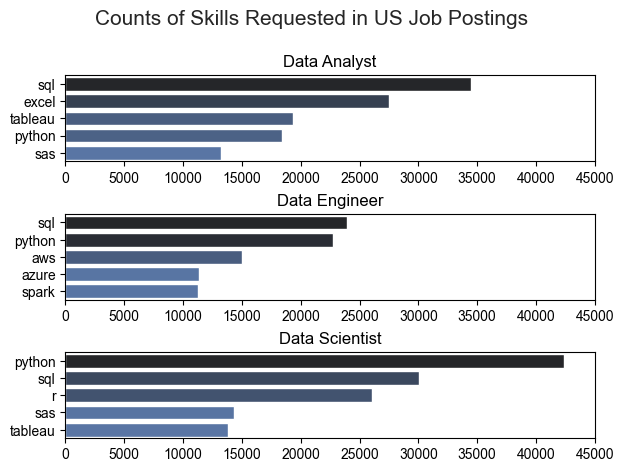

In [6]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

## Convert Counts to Percentages

Raw counts can be misleading since some roles have way more postings than others. Converting to percentages gives a fairer comparison across roles.

First, we need the total number of job postings per title to use as the denominator.

In [7]:
# Use original df to get the count of job titles
df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,67816
1,Data Scientist,58830
2,Data Engineer,35080
3,Senior Data Scientist,12946
4,Senior Data Analyst,11791
5,Senior Data Engineer,9289
6,Business Analyst,7382
7,Software Engineer,1814
8,Machine Learning Engineer,921
9,Cloud Engineer,423


Now merge the skill counts with the total postings per role and calculate the percentage.

In [8]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,vue.js,Business Analyst,1,7382,0.013546
1866,arch,Business Analyst,1,7382,0.013546
1867,asana,Machine Learning Engineer,1,921,0.108578
1868,no-sql,Machine Learning Engineer,1,921,0.108578


## Plot Percentage Count

Plot the top 5 skills for each role as horizontal bar charts with percentage labels.

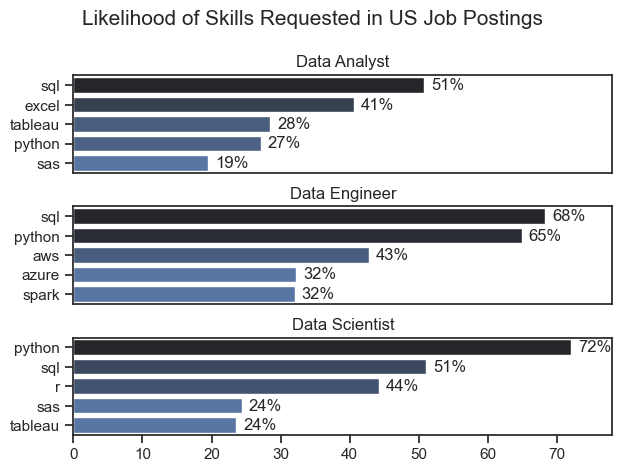

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()